In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [2]:
%R source('plots/colors.R');

Inputs:

In [3]:
__inputs__ = create_paths(
    path='data/integration/',
    csv=[
        'rna', 'rna_shared', 'protein', 'protein_shared',
        'patients_with_both', 'genes_in_both'
    ]
)
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

Outputs:

In [4]:
correlations_path = 'data/integration/' + 'correlations.csv'
differential_correlations_path = 'data/integration/' + 'differential_correlations.csv'

Load inputs:

In [5]:
load_inputs(
    globals(), silent=True,
    loaders={'patients_with_both': Series.from_csv, 'genes_in_both': Series.from_csv},
)

In [6]:
patients_union = list(rna.columns | protein.columns) 
clinical = read_csv(clinical_path, index_col=0).loc[patients_union]
from plots.annotations import generate_patient_annotations
patient_annotations = generate_patient_annotations(clinical)

### 1. Small but noticeable fraction of measurements is missing RNA-seq counts

In [7]:
values = pd.concat([
    rna_shared.reset_index().melt(id_vars='index').assign(omic='RNA'),
    protein_shared.reset_index().melt(id_vars='index').assign(omic='Protein')
])
values['Meningitis'] = values.variable.map(clinical.Meningitis)
values.head(2)

,index,variable,value,omic,Meningitis
0,FGR,001.TMD,6.941349,RNA,Tuberculosis
1,CFH,001.TMD,-1.189430,RNA,Tuberculosis


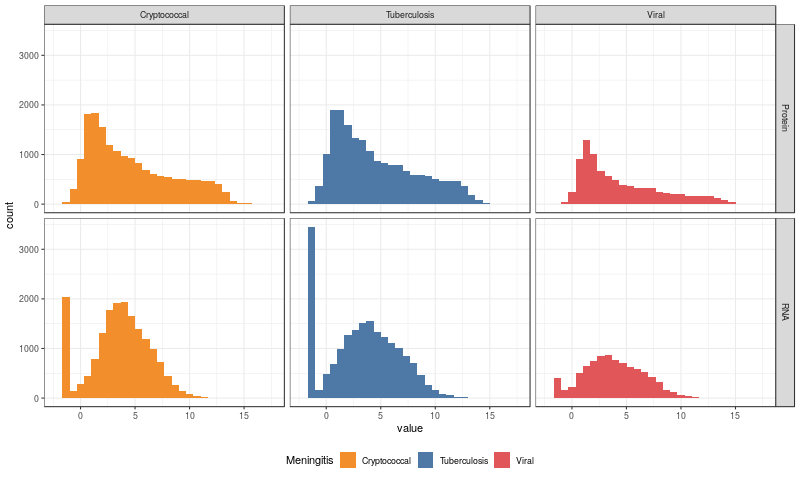

In [8]:
%%R -w 800 -i values
(
    ggplot(values, aes(x=value, fill=Meningitis))
    + facet_grid('omic ~ Meningitis')
    + geom_histogram()
    + scale_fill_manual(values=patient_colors$Meningitis)
    + nice_theme
)

RNA-seq data has clearly many proteins that were not registered for this subset of patients (but not necessarily for all patients - in such case those should have been filtered).
The values appear negative due to the log transformation:

In [9]:
from math import log2

In [10]:
damping_factor = 0.25
log2(0 + damping_factor), log2(1 + damping_factor)

(-2.0, 0.32192809488736235)

And it's about 15% of all RNA values:

In [11]:
values['is_low_count'] = values.value < 0
rna_values = values.query('omic == "RNA"')
len(rna_values.query('is_low_count')) / len(rna_values)

0.15048694112439132

In [12]:
def summarize_low_counts(values):
    return (
        values.groupby(['Meningitis', 'index']).is_low_count.mean().sort_values(ascending=False)
        .to_frame('ratio').reset_index()
    )

In [13]:
rna_low_ratio = summarize_low_counts(rna_values)

There are a few proteins with no (VIP in viral) or almost no counts across all patients in subgroups:

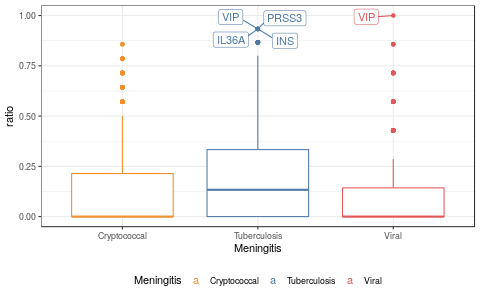

In [14]:
%%R -i rna_low_ratio -h 300
top = rna_low_ratio[rna_low_ratio$ratio >= 0.9,]
(
    ggplot(rna_low_ratio, aes(x=Meningitis, y=ratio, color=Meningitis))
    + geom_boxplot() + color_meningitis + nice_theme
    + ggrepel::geom_label_repel(aes(label=index), data=top, nudge_x=c(-0.2,0.2), direction='y')
)

- VIP - signalling: IL-6, GPCR, Gα.
- IL36α - interleukin 36, inflammatory response, NF-kappa-B and MAPK signaling pathways; thought to be an important factor in counteracting microbial and viral immune evasion [(Jensen LE, 2017)](https://www.ncbi.nlm.nih.gov/pubmed/28811383)
- INS - insulin
- PRSS3 (Trypsin-3) - immune system, neutrophil degranulation, antimicrobial peptides

With even more genes having transcripts completely undetected in the "definite" subgroup of tuberculosis:

In [15]:
tmd_rna_low_ratio = summarize_low_counts(rna_values[rna_values.variable.str.endswith('TMD')])
rna_absent_in_tmd = tmd_rna_low_ratio[tmd_rna_low_ratio.ratio == 1]
rna_absent_in_tmd

,Meningitis,index,ratio
0,Tuberculosis,C8A,1.0
1,Tuberculosis,PRSS3,1.0
2,Tuberculosis,FGB,1.0
3,Tuberculosis,IL20,1.0
4,Tuberculosis,DKKL1,1.0
5,Tuberculosis,IGFBP6,1.0
6,Tuberculosis,HIST1H3D,1.0


- C8A - bacteria killer
- PRSS3 (Trypsin-3) - [as above] immune system, neutrophil degranulation, antimicrobial peptides
- FGB - blood clotting, signaling cascades, platelets, a lot of signaling + VEGFA-VEGFR2
- IL20 - an interleukin 
- DKKL1 - negative regulator of Wnt signaling (dickkopf-like protein)
- IGFBP6 - potential biomarker for TB in HIV+ see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/
- HIST1H3D  - "HIV-1 Tat peptides bind core histones H2A, H2B, H3 and H4, and Tat protein recruits histone acetyltransferases to the HIV-1 LTR promoter leading to acetylation of histones H3 and H4, derepressing chromatin structure and increasing NFkappaB responsiveness"

On IGFBP6:
  > "The remaining two proteins in the HIV+ panel, IGFBP6 and TAGLN2 have unknown roles in infectious diseases. Of note, ligands of IGFBP6 are reduced in sera and pleural fluids of subjects with tuberculous and non-tuberculous pleuritis (Le Bouc et al., 1997)."
 >
 > ![](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/bin/gr3.jpg)
 >
 > Fig 3: Differential expression in sera, fold change. ORD = Other respiratory diseases, NI = not infected, LI = latent TB infection, TB = TB infection

From the fig 3 (above) I gather that this is is low against controls (especially in HIV+), and slightly higher against other respiratory diseases (but still not very high).

**TODO** Come to think of it: is the default mean expression filter of DESeq2 wise enough to NOT reject such (completely undetected in one group) cases? Maybe not: fold change in any method would be NaN or zero (but for the damping factor influence, thus more likely +/-∞)! Usually such cases are rare, though such proteins would be perfect biomarkers!

In [16]:
healthy_controls = protein.columns[protein.columns.str.endswith('HC')]
protein_hc = protein.loc[genes_in_both][healthy_controls].reset_index().melt(id_vars='index').assign(omic='Protein', is_low_count=F)

In [17]:
# actually, I could add the patients which are outside of the shared subset here
values_with_hc = pd.concat([values, protein_hc])
values_with_hc['Meningitis'] = values_with_hc.variable.map(clinical.Meningitis)

absent_tmd = values_with_hc.set_index('index').loc[rna_absent_in_tmd['index']].reset_index()

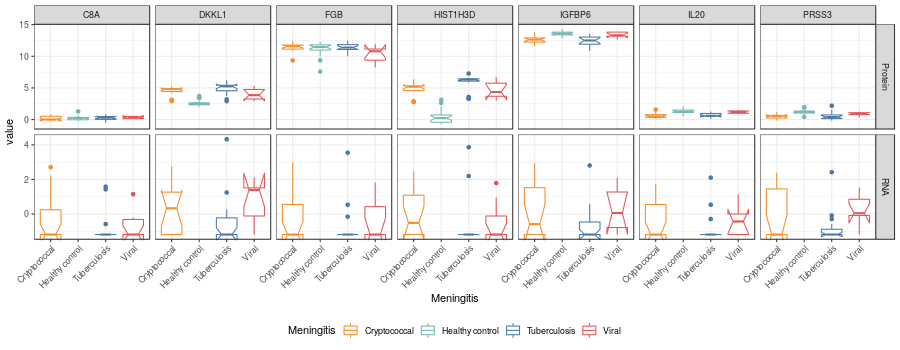

In [18]:
%%R -i absent_tmd -w 900 -h 350
(
    ggplot(absent_tmd, aes(x=Meningitis, y=value, color=Meningitis))
    + geom_boxplot(notch=T) + facet_grid('omic ~ index', scale='free_y')
    + nice_theme + color_meningitis
    + theme(axis.text.x=element_text(angle=45, hjust=1))
)

None of them seem to be differential (for our groups of interest) but there must be a story to be told on IGFBP6 (why is it high in SOMAScan?).

### 2. The RNA and protein profiles are correlated, but not highly

Overall the "naive" correlation (Spearman) between the patient RNA and protein profiles are low:

In [19]:
from scipy.stats import spearmanr

In [20]:
profile_correlations = DataFrame([
    {
        'patient': patient,
        'correlation': spearmanr(protein_shared[patient], rna_shared[patient]).correlation,
        'Meningitis': clinical.loc[patient].Meningitis
    }
    for patient in patients_with_both
]).set_index('patient')

In [21]:
profile_correlations.correlation.mean()

0.11118337072352547

In [22]:
assert profile_correlations.correlation.mean() == profile_correlations.correlation.abs().mean()

And always positvie:

In [23]:
assert (profile_correlations.correlation > 0).all()

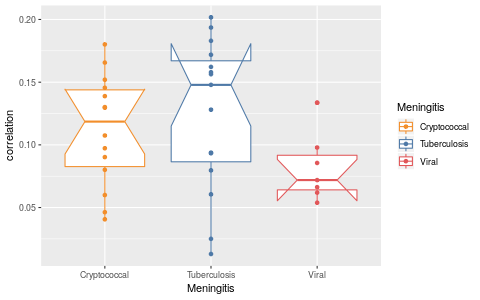

In [24]:
%%R -i profile_correlations -h 300
(
    ggplot(profile_correlations, aes(x=Meningitis, y=correlation, color=Meningitis))
    + geom_boxplot(notch=T) + geom_point()
    + color_meningitis
)

**The correlations for viral meningitis are lower than those for Crypto and TB.**

Note: the distinction betwen (2, above) and (3, below) is similar to "ecological"/"aggregate" vs "individuals" correlations problem. Above I averaged correlations for each gene, while below I consider them independently.

### 3. Correlations for gene-protein pairs are slightly higher
(with RNASeq-SOMAScan pairs having low RNASeq skipped)

If we were to look at the RNA/protein correlations across the samples, we see the absolute mean correlation to be even higher:

In [25]:
def calc_correlations(rna, protein, method=spearmanr, filter_low_rna_seq=True):
    cor_list = []
    
    for gene in genes_in_both:
        
        r = rna.loc[gene]
        p = protein.loc[gene]
        
        if filter_low_rna_seq:
            # filter out samples (patients) with too few RNA-seq reads for this protein/gene (see above)
            patients_with_enough_rna = r[r > 0].index
            p = p[patients_with_enough_rna]
            r = r[patients_with_enough_rna]
        
        cor = method(r, p)
        
        cor_list.append({
            'gene': gene,
            'rna_abundance': mean(r),
            'protein_abundance': mean(p),
            'mean_abundance': mean(r + p),
            'cross_abundance': mean(r) * mean(p),
            'correlation': cor[0],
            'pvalue': cor[1],
            'n': len(patients_with_enough_rna)
        })
    return DataFrame(cor_list).set_index('gene')

In [26]:
correlations = calc_correlations(rna_shared, protein_shared)
correlations.correlation.abs().mean()

0.17292477460678934

For example the most negatively correlated pairs are:

In [27]:
correlations.sort_values('correlation').head()

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance
gene,,,,,,,
HIST1H3D,-0.966667,8.044816,6.210554,9,4.369369,0.000022,1.841185
IL17A,-0.779412,1.922482,2.781474,16,1.282721,0.000372,1.498752
PRSS3,-0.745455,0.885991,1.977648,11,0.685869,0.008455,1.291778
IL36A,-0.650000,5.735279,5.287937,9,3.764366,0.058073,1.523571
CA1,-0.644269,7.303764,5.855095,23,4.053057,0.000907,1.802038


$$\text{cross_abundance} = \text{protein_abundance} \times \text{mean_abundance}$$

Looking for biomarkers we are mostly interested in effects:
 - supported consistently by larger number of observations
 - for more abundant proteins and transcripts

Use of P-value can address the first issue and filtering will resolve the second - I will adjust FDR filtering low abundance pairs with genefilter package:

In [28]:
%%R
import::here(filter_by_mean_expression, .from='helpers/independent_hypothesis.R')

add_filtered_fdr = function(correlations, expression_col, alpha=0.1) {
    correlations$FDR = filter_by_mean_expression(
        correlations, alpha, expression_col=expression_col, pvalue_col='pvalue', show_plot=F,
        use_deseq2_method=F
    )
    f = sum(sapply(correlations$FDR, is.na))
    p = sum(sapply(correlations$pvalue, is.na))
    print(paste('Filtered:', f - p))
    correlations
}

In [29]:
from helpers.r import r_function

In [30]:
add_filtered_fdr = partial(r_function, 'add_filtered_fdr')

In [31]:
correlations = add_filtered_fdr(correlations, 'cross_abundance', 0.1)
correlations.sort_values('FDR').head(2)

[1] "Filtered: 408"


,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance,FDR
HIST1H3D,-0.966667,8.044816,6.210554,9,4.369369,0.000022,1.841185,0.018253
FCN1,0.617087,24.109512,10.467347,35,3.422092,0.000079,7.045254,0.033329


### 4. Most significant, highly abundant, highly correlated transcript-protein pairs

Positive correlation can tells us about the type of the cell (if there are cell type specific proteins expressed and measured).

Negative correlation can highlight proteins which are expressed but then exported or used up in another way (binding to complexes - own or foreign, signaling).

These correlations characterize CSF cells in meningitis, but we cannot claim any relation to the healthy individuals yet.

In [32]:
def best_hits(correlations, n=5, sort='FDR'):
    dfs = []
    for direction in ['positively', 'negatively']:
        neg = direction == 'negatively'
        c = correlations[correlations.correlation * (-1 if neg else +1) > 0].sort_values(sort)
        for k in c.head(n).index:
            dfs.append(
                DataFrame(dict(
                    RNA=rna_shared.loc[k], Protein=protein_shared.loc[k]
                )).assign(
                    direction=direction, gene=k, FDR=c.loc[k].FDR, p=c.loc[k].pvalue,
                ).rename_axis('patient').reset_index()
            )
    df = pd.concat(dfs)
    df['Meningitis'] = df.patient.map(clinical['Meningitis'])
    df.gene = pd.Categorical(df.gene, categories=correlations[sort].abs().sort_values().index, ordered=T)
    return df

In [33]:
df = best_hits(correlations, n=5, sort='FDR')

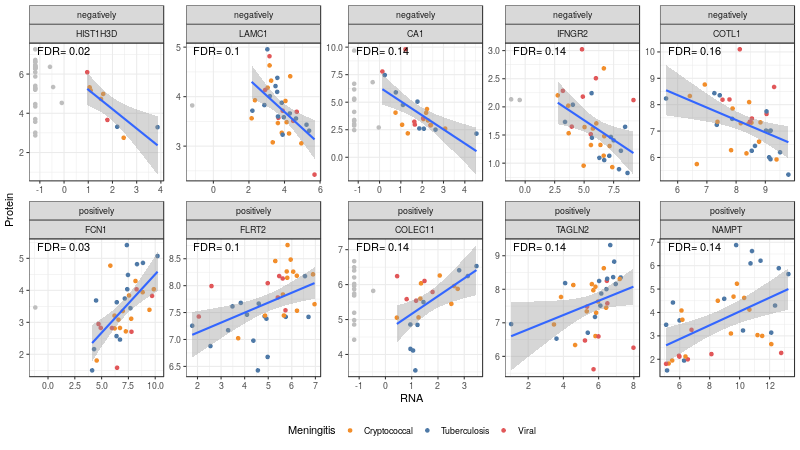

In [34]:
%%R -i df -w 800 -h 450
low_rna = df[df$RNA < 0,]
high_rna = df[df$RNA >= 0,]
(
    ggplot(high_rna, aes(x=RNA, y=Protein))
    + facet_wrap('direction ~ gene', 2, scale='free')
    + geom_point(aes(color=Meningitis))
    + geom_point(color='grey', data=low_rna)
    + geom_smooth(method = "lm")
    + geom_text(aes(label=paste('FDR=', round(FDR, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15)
    + color_meningitis + nice_theme
)

Here are RefSeq based summaries for the above hits:

The most negatively correlated 5:
- HIST1H3D - a histone; may be important in cell proliferation, apoptosis and cell cycle progression (in cancer); RNASeq reads absent in all but two TB patients(!)
- LAMC1 - extracellular matrix glycoprotein; "Upregulated by HIV infection or Tat protein"
- CA1 - zinc metalloenzyme; involved in formation of cerebrospinal fluid (among others); cytosolic, high in erythrocytes; potential oncogene (abnormal cell calcification, apoptosis and migration in breast cancer)
- IFNGR2 - receptor for Interferon gamma (variants are a cause of susceptibility to **mycobacterial** infections!)
- COTL1 - involved in many autoimmune disorders and cancers; related to IL-24/TGF-beta signaling

The most positively correlated 5:
- FCN1 - predominantly expressed in peripheral blood leukocytes; immune system; Neutrophil degranulation; Ebolva virus infection
- FLRT2 - neural development; cell adhesion molecule; possible role in cellular growth and proliferation; tumour suppressor in breast cancer
- COLEC11 - secreted protein; **"important roles in the innate immune system by binding to carbohydrate antigens on microorganisms, facilitating their recognition and removal"**
- TAGLN2 - "thought to be a tumor suppressor", HIV-1 likes this protein: gp120 upregulates it and it needs it to replicate; Platelet activation, signaling and aggregation
- NAMPT - NAPRTase family; involved in many important biological processes, including metabolism, stress response and aging

Further down the list:

In [35]:
export_columns = ['correlation', 'n', 'protein_abundance', 'rna_abundance', 'pvalue', 'FDR']
significant_table = correlations.sort_values('FDR')[export_columns]
significant_table.to_csv(correlations_path)

In [36]:
show_table(significant_table.head(20))

,correlation,n,protein_abundance,rna_abundance,pvalue,FDR
HIST1H3D,-0.966667,9,4.369369,1.841185,0.000022,0.018253
FCN1,0.617087,35,3.422092,7.045254,0.000079,0.033329
LAMC1,-0.566106,35,3.768237,3.765978,0.000393,0.099628
FLRT2,0.552896,36,7.678617,4.974119,0.000470,0.099628
NAMPT,0.515830,36,3.667793,8.727463,0.001282,0.140664
COLEC11,0.648786,22,5.489469,1.644922,0.001089,0.140664
CA1,-0.644269,23,4.053057,1.802038,0.000907,0.140664
TAGLN2,0.512999,36,7.595435,5.709453,0.001377,0.140664
IFNGR2,-0.523300,34,1.627658,5.966830,0.001495,0.140664
COTL1,-0.490862,36,7.295692,8.262931,0.002368,0.160997


#### 4.1 The most significant low-expressed pairs

In [37]:
low_expressed = correlations[correlations.FDR.isnull()]
df = best_hits(low_expressed, n=5, sort='pvalue')

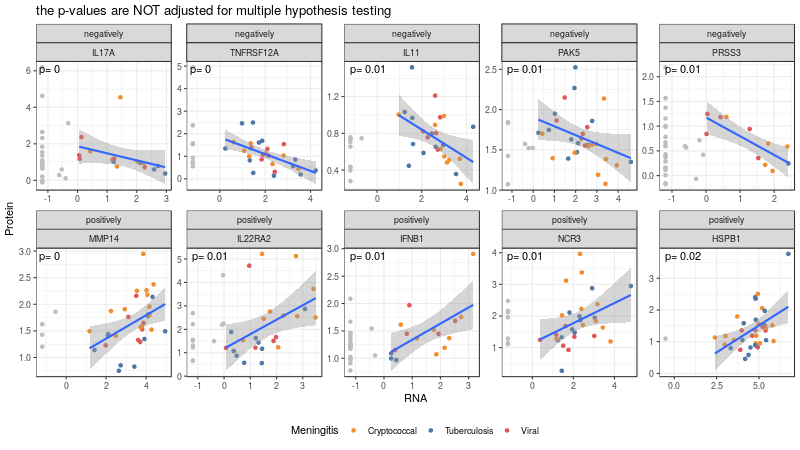

In [38]:
%%R -i df -w 800 -h 450
low_rna = df[df$RNA < 0,]
high_rna = df[df$RNA >= 0,]
(
    ggplot(high_rna, aes(x=RNA, y=Protein))
    + facet_wrap('direction ~ gene', 2, scale='free')
    + geom_point(aes(color=Meningitis))
    + geom_point(color='grey', data=low_rna)
    + geom_smooth(method = "lm")
    + geom_text(aes(label=paste('p=', round(p, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15)
    + color_meningitis + nice_theme
    + ggtitle('the p-values are NOT adjusted for multiple hypothesis testing')
)

- Either interleukins are enriched in SOMAScan design or those have some special role here; correlations:
  - negative: IL17A, IL11
  - positive: IL22RA2 (receptor) [but IL22 is not expressed in 80% of TB patients, 60% of Crypto and 50% of Viral...]
- Interferon Β (IFNB1) has positive correlation while Receptor for Interferon γ (IFNGR2) has negative one
- PRSS3 is not expressed in 93% of the TB patients! (or at least not detected)

In [39]:
rna_low_ratio[rna_low_ratio['index'] == 'IL22']

,Meningitis,index,ratio
24,Tuberculosis,IL22,0.800000
223,Cryptococcal,IL22,0.571429
358,Viral,IL22,0.428571


### 5. Negative correlations are less frequent than positive correlations

(thus should not invalidate the RNASeq analyses, but are an important factor to consider)

In [40]:
# only use pvalue < 0.5, otherwise we are lookking at meaningless noise
# (and I assume that p-values are callibrated up to this level)
not_noise = correlations.query('pvalue < 0.5')

positive_correlations = not_noise.query('correlation > 0')
negative_correlations = not_noise.query('correlation < 0')

In [41]:
len(positive_correlations)

437

In [42]:
len(negative_correlations)

248

#### 5.1 Trends in the pathways space of the positively and negatively correlated pairs differ

Using camera with 1 - p-value gives us an over-representation analysis proxy, but this is actually even worse as it does not use background. Thus, please do not take the FDR/PValue seriously, these are not valid.

In [43]:
from gsea_api.expression_set import ExpressionSet
from gsea_api.molecular_signatures_db import GeneMatrixTransposed
from helpers.gse import collection_to_R

reactome_new_symbol = GeneMatrixTransposed.from_gmt('ReactomePathways.gmt', name='reactome_new_symbol')
collection_to_R(reactome_new_symbol, trim_to=set(genes_in_both))

%R camera = function(x) {limma::cameraPR(x, reactome_new_symbol)}
camera = partial(r_function, 'camera')

In [44]:
# well, actually why would there be any trend for positive correlations?
# this is just how the "normal" cell in the simplest version of the central dogma works,
# so even with proper ORA I would not expect any serious significant signal here
camera(1 - positive_correlations.pvalue).head()

,NGenes,Direction,PValue,FDR
Non-integrin membrane-ECM interactions,8.0,Up,0.002892,0.969483
Intrinsic Pathway for Apoptosis,5.0,Up,0.013599,0.969483
Signaling by PTK6,9.0,Up,0.016492,0.969483
Signaling by Non-Receptor Tyrosine Kinases,9.0,Up,0.016492,0.969483
Detoxification of Reactive Oxygen Species,2.0,Down,0.019178,0.969483


In [45]:
# kind of as expected ("gut feeling"?), but needs proper ORA framework
camera(1 - negative_correlations.pvalue).head()

,NGenes,Direction,PValue,FDR
Immune System,101.0,Up,0.001514,0.675596
Cytokine Signaling in Immune system,57.0,Up,0.002538,0.675596
Interleukin-10 signaling,6.0,Up,0.003147,0.675596
Signaling by Interleukins,39.0,Up,0.004533,0.729791
Interleukin-4 and Interleukin-13 signaling,14.0,Up,0.016611,0.989134


I verified using gProfiler and got no significant hits.

In [46]:
# neg = negative_correlations.index

In [47]:
#%%R -i neg -i genes_in_both -o go_result
#go_result <- gprofiler2::gost(neg, custom_bg=genes_in_both, ordered_query=T, significant=T)
#head(go_result)

### 6. A look at the consistently (highly expressed gene-highly abundant protein) pairs (across all groups)

In [48]:
correlations.sort_values('cross_abundance', ascending=False).head(10)

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance,FDR
B2M,-0.286229,128.402041,22.684506,36,11.836889,0.090573,10.847617,0.551396
IGHG1,0.044530,112.926118,21.255319,36,10.772678,0.796500,10.482642,0.977732
YWHAZ,-0.180695,112.116291,21.524917,36,12.689689,0.291599,8.835227,0.780203
SELL,-0.108366,107.915142,21.189183,36,12.675513,0.529281,8.513671,0.919029
IGHA1,0.027542,106.507769,20.779532,36,11.589543,0.873315,9.189989,0.979478
ALDOA,-0.025740,102.830890,20.768459,36,12.620596,0.881542,8.147863,0.979478
HNRNPA2B1,0.110682,100.633336,20.071471,36,10.323219,0.520461,9.748252,0.918138
CTSD,-0.224453,98.109711,20.423032,36,12.694528,0.188155,7.728504,0.671664
TNFRSF1B,-0.281081,96.718850,20.212132,36,12.432805,0.096786,7.779326,0.565365
YWHAB,0.037580,95.848418,19.998636,36,12.033510,0.827739,7.965125,0.979191


Top 5:
- B2M - β2-microglubulin: related to MHC, HIV Infection (Host Interactions), IL-12, interferon, TCR singaling
- IGHG1 - immunoglobulin heavy constant gamma; immune system, IL4, IL13
- YWHAZ - mediates signal transduction, lots of pathways, interacts with insulin receptor substrate 1
- SELL - strong association with HIV-1; proposed as biomarker for tuberculosis in HIV negative patients [(Achkar et al, 2015)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4588417/) (well, maybe this is like checking if they may happen to have latent HIV...)
- IGHA1 - immunoglobulin heavy constant alpha 1; IL17; antibacterial humoral response

Note: I am finding many of the proteins that I check to be associated with to Systemic Lupus. 

### 7. Differential correlations analysis

Are there any pairs positively correlated in one meningitis but negatively in the other?

In [49]:
tb_patients = patients_with_both[patients_with_both.str.contains('TMD|TMR|TMS')]
cm_patients = patients_with_both[patients_with_both.str.contains('CM')]

correlations_tb = calc_correlations(rna_shared[tb_patients], protein_shared[tb_patients])
correlations_cm = calc_correlations(rna_shared[cm_patients], protein_shared[cm_patients])

#### 7.1 Absolute correlations for TB are (on average) higher, and the correlations are more positive for TB

In [50]:
joint_correlations = pd.concat([
    correlations_cm.assign(Meningitis='Cryptococcal'),
    correlations_tb.assign(Meningitis='Tuberculosis')
])
joint_correlations = joint_correlations.assign(abs_correlation=joint_correlations.correlation.abs())

Note: Shapiro-Wilk Normality Test for abs_correlation : p-value = < 0.001
Note: Bartlett's test for homogeneity of variances for factor Meningitis : p-value = < 0.001
Note: Shapiro-Wilk Normality Test for correlation : p-value = 0.001
Note: Bartlett's test for homogeneity of variances for factor Meningitis : p-value = < 0.001


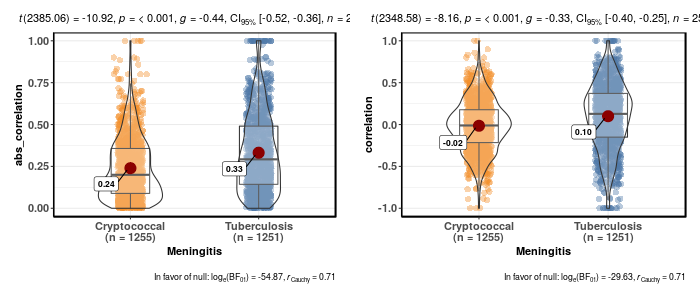

In [51]:
%%R -i joint_correlations -w 700 -h 300
cowplot::plot_grid(
    ggstatsplot::ggbetweenstats(data=joint_correlations, x='Meningitis', y='abs_correlation') + color_meningitis,
    ggstatsplot::ggbetweenstats(data=joint_correlations, x='Meningitis', y='correlation') + color_meningitis
)

And the effect persits after filtering out the non-sigificant hits:

In [52]:
joint_correlations_without_noise = joint_correlations.query('pvalue < 0.1')
joint_correlations_without_noise.groupby('Meningitis').mean()[['correlation', 'abs_correlation']]

,correlation,abs_correlation
Meningitis,,
Cryptococcal,-0.103565,0.611850
Tuberculosis,0.214818,0.635185


- Maybe more proteins measured in the TB are produced "on-site" (in the cells present in the CSF) rather imported with migrating cells which matured outside of the CSF?
- Maybe there are just more proteins measured in the TB, thus it's easier to get a high correlation?

In [53]:
clinical.groupby('Meningitis').Protein.mean().to_frame().T

Meningitis,Bacterial,Cryptococcal,Healthy control,Tuberculosis,Viral
Protein,2.76,1.298889,0.4088,2.894688,0.6925


#### 7.2 In the subsets there are some perfect correlations, but with support from very few patients

Filtering/weighting is thus needed for the subsets as such hits are not very interesting:

In [54]:
correlations_tb.sort_values('pvalue').head(2)

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance
gene,,,,,,,
CST4,1.0,0.069172,0.952579,3,0.079200,0.0,0.873379
DKKL1,-1.0,9.310827,6.736924,3,4.795245,0.0,1.941679


In [55]:
correlations_cm.sort_values('pvalue').head(2)

,correlation,cross_abundance,mean_abundance,n,protein_abundance,pvalue,rna_abundance
gene,,,,,,,
CA9,1.0,2.969442,3.470524,4,1.939450,0.0,1.531074
IL17F,-1.0,-0.010303,2.128643,3,-0.004829,0.0,2.133472


I will be weighting the hits by minimal $n$ across the compared groups.

In [231]:
def absolute_correlation_difference(cm, tb):
    return (cm.correlation - tb.correlation).abs()

In [274]:
cm_tm = DataFrame(dict(
    cm_correlation=correlations_cm.correlation,
    tb_correlation=correlations_tb.correlation,
    diff=absolute_correlation_difference(correlations_cm, correlations_tb),
    mean_abundance=correlations_cm.mean_abundance + correlations_tb.mean_abundance,
    cross_abundance=correlations_cm.cross_abundance * correlations_tb.cross_abundance,
    n=correlations_cm.n + correlations_tb.n,
    cm_n=correlations_cm.n,
    tb_n=correlations_tb.n,
    cross_n=correlations_cm.n * correlations_tb.n
)).dropna().sort_values('diff', ascending=False)

cm_tm.head(2)

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,n,cm_n,tb_n,cross_n
gene,,,,,,,,,
CA9,1.0,-1.0,2.0,7.232411,10.476257,6,4,2,8
EFNA2,0.8,-1.0,1.8,20.737359,218.871458,6,4,2,8


Obviously perfect correlation for $n=2$ is not interesting...

#### Significance estimation and weighting

For the permutation test we can:
- a) reshuffle labels of patients within phenotypes (here: within meningitis subgroups), or
- b) keep the paired observations together but reshuffle phenotypes (here: meningitis type), or
- c) reshuffle entire phenotypes (all labels without any prior separation except for keeping omics separately)

The latter is used in GSEA, but GSEA operates on aggregate rather level than using paired hypothesis.

Rephrasing in terms of tested hypotheses, the two scenarios asssess null for:
- a) "no structure" hypothesis - A: the difference in relations (as strong as observed) of RNA and Protein levels for given groups is stronger than expected from random pairing of the RNA-Protein data.
- b) "no difference between groups" - A: the difference in relations as strong as observed would not be seen from random assignement of patients to TB/crypto groups
- c) "no difference between groups and/or no structure" - A: the relations as strong as observed would not come out from completely random data

By rejecting the (a) null we can claim that the effects in the experimental measurement procedure which could be attributed to random factors and differ between RNA and Protein measurments of a single patient (e.g. the time delay in sequencing which results from the data being processed in two different centres) do not explain the observed relation.

Ideally we would want to reject all three hypotheses, but not rejecting either (a) or (b) gives us a meaningful interpretation as well.

For sake of completness, further to the mentioned permutation scenarios we could reshufle RNA-protein assignment, but it is not obvious to me what would be the intepretation of such a test without making some additional assumptions.

#### Filtering by p-value from Spearmanr?

One way to reduce the number of tests is to only consider significant correlations in the first place. However, there is dependence between such filtering and the filtering that we would like to do later on, thus in order to prevent having deflated FDR q-values I will not do that. On the other hand this could also inflate the p-values in permutation testing.

Importantly (according to the documentaiton) the p-values from `scipy.stats.spearmanr` are not reliable for datasets as small as our gene-wise RNA-protein correlations (< 40 observations each):

> The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
[[source]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html)

#### Similar methods in other publications 

Literature search for methods that measure the change in correlation:
- ["Integrative analysis reveals disrupted pathways regulated by microRNAs in cancer"](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5814839/#M1) makes use of:
 - absolute difference in the Spearman correlations
 - permutation tests (Equation 1, Table 1, Figure 1; Note: the figure is a very interesting inspiration for a cartoon!)
- ["Modelling high contentproteomics data in a signalling context" thesis](https://www.ebi.ac.uk/sites/ebi.ac.uk/files/shared/documents/phdtheses/Terfve.pdf), pages 67-73:
 - uses absolute difference in Pearson correlations
 - names the figure 3.10 "Comparative analysis of correlation patterns between [...]" - sounds slightly better than "differential correlations analysis" to me.
 - interestingly, the author looks at correlations between proteins sharing a functional link (which could be a next step if this project was a PhD project).
 - significance testing on the level of individual correlations only
- ["Exceptional Model Mining"](https://link.springer.com/content/pdf/10.1007/978-3-540-87481-2_1.pdf) explains a mathematical framework for correlation models in 3.1. They:
 - note the problem of the absolute correlations difference not accounting for the size of the group.
 - propose to use entrpy of the split, which is adequate to their modeling objective (search for two subgroups) but not to ours.
 - propose a significance measure for correlation difference: assuming bivariate normal distribution of correlation coefficients they use Fisher z-transform to make the data approximately normal and follow with standard p-value calculation procedure.
 
This search was not exhaustive. Search terms: "absolute correlation difference", "absolute correlations difference", "absolute difference of correlations".

In [386]:
from helpers.correlations.comparative import ComparativeCorrelations

cm_tm_comparative = ComparativeCorrelations(
    rna=rna_shared,
    protein=protein_shared,
    tb_patients=tb_patients,
    cm_patients=cm_patients,
    method=spearmanr,
    genes_in_both=genes_in_both
)

Even with the permutation testing, effects of the "perfect correlations" from groups with very few patients with non-zero RNA data dominate the top results:

In [275]:
p_adjust = partial(r_function, 'p.adjust')

def compute_and_add_p_values(target, null, suffix='', fdr_method='BH'):
    p_name = f'p_value{suffix}'
    q_name = f'FDR{suffix}'
    target = copy(target)
    target[p_name] = null.gt(target['diff'], axis='rows').mean(axis='columns')
    target[q_name] = p_adjust(target[p_name], fdr_method)
    return target.sort_values(q_name)

In [279]:
absolute_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=1000
)
compute_and_add_p_values(cm_tm, absolute_diff_b, suffix='.pairs').head()

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,p_value.pairs,FDR.pairs
gene,,,,,,,,,,,
CA9,1.000000,-1.000000,2.000000,7.232411,10.476257,...,4,2,8,0.000,0.000000
FGB,-0.800000,1.000000,1.800000,26.125247,341.458704,...,5,2,10,0.000,0.000000
MMP1,0.800000,-1.000000,1.800000,9.977144,16.873110,...,4,2,8,0.000,0.000000
CNDP2,-0.019780,0.867857,0.887637,18.486985,216.616828,...,14,15,210,0.000,0.000000
MAP2K4,-0.604396,0.661538,1.265934,17.274548,344.637854,...,14,14,196,0.001,0.156375


Therefore the final metric includes weighting by the number of patients with detectable RNA trasncripts levels for specific gene:

I aimed to choose a weight function $w$ which satisfies following objectives:
  - I) down-weight genes with few patients in one of the groups
  - II) up weight genes with more patients

To address the aims I and II, two appraoches were considered: min(cm.n, tb.n) and $cm.n * tb.n$. The latter was chosen as the former does not satisfy II.

Because multiplication of two positives, comparable numbers transforms the average number of patients from $n$ to $\approx n^2$, to prevent the over-weightning of the genes expressed in large number of patients, a square root transfrom (sqrt) was introduced which is more natural in this setting than the log-transform (a popular alternative), because the two operations (multiplication and square root) compose into geometric mean.

Why geometric mean $\sqrt{cm.n \cdot tb.n}$ is better than arithmetic mean $\frac{cm.n + tb.n}{2}$? See examples:
 - where one side has few expressed genes the former will give us 0, the latter some positive number (and we would prefer 0 as it shows how non-interpretable is the value).
 - consider two cases, both with 30 patients in total:
     - 10, 20: mean = 15, sqrt(10*20) = 14.142135624
     - 15, 15: mean = 15, sqrt(15*15) = 15
 
 As we would prefer to trust the second case, we can see another advantage of the geometric mean. Note: this is in a relation to the split entropy(?).
 
More examples:
- 2, 28: mean = 15, sqrt(2*28) = 7.483314774

In [314]:
from math import sqrt

def geometric_absolute_correlation_difference(cm, tb):
    return (cm.correlation - tb.correlation).abs() * (cm.n * tb.n).apply(sqrt).apply(sqrt)

In [299]:
geometric_absolute_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=geometric_absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=100
)

In [321]:
compute_and_add_p_values(cm_tm, geometric_absolute_diff_b, suffix='.pairs').sort_values('p_value.pairs').head()

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,p_value.pairs,FDR.pairs
gene,,,,,,,,,,,
CA9,1.000000,-1.0,2.000000,7.232411,10.476257,...,4,2,8,0.33,1.0
MMP1,0.800000,-1.0,1.800000,9.977144,16.873110,...,4,2,8,0.36,1.0
CST4,-0.500000,1.0,1.500000,3.043198,0.014540,...,3,3,9,0.42,1.0
CSRP3,0.542857,-1.0,1.542857,7.209161,2.993545,...,6,2,12,0.52,1.0
MMP12,0.464286,-1.0,1.464286,8.304737,9.746721,...,7,2,14,0.57,1.0


However, weighting by the geometric mean does not work with the permutation test algorithm because:
- genes which are not expressed in most of the patients often get zero. If those are also perfectly correlated, the p-value defined as mean(observed > null) will be also zero (0 > 0 = False) for considerable number of cases.
- for cases other than A, the $n$ changes. As $n$ changes, the $w$ result changes and influences the weighted correlation drastically.
  - this is essentialy addition of another distribution being a function of total $n$ for each gene; we see a lot of "noise" originating from the number of measured transcripts, but rather than increasing stability of the $r$ with increasin $n$, it decreases it; this is the correct behaviour, but rather than helping us highlight the interesting genes, it highlights how weak unstable is the weightning function.

The normalization to the total $n$ available for the gene will solve stability isues, but make the weight invariant to the number of samples, thus making it's contribution similar to that of the entropy weighting.

$$w = \frac{\sqrt{cm.n \cdot tb.n}}{cm.n + tb.n}$$

In [330]:
def weighted_absolute_correlation_difference(cm, tb):
    return (cm.correlation - tb.correlation).abs() * (cm.n * tb.n).apply(sqrt) / (cm.n + tb.n)

In [331]:
s_weighted_absolute_diff_b = cm_tm_comparative.compute_null_distribution(
    metric=weighted_absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=100
)

In [374]:
compute_and_add_p_values(cm_tm, s_weighted_absolute_diff_b, suffix='.pairs').sort_values('p_value.pairs').head()

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,p_value.pairs,FDR.pairs
gene,,,,,,,,,,,
MPL,0.700000,-0.5,1.200000,2.607451,-0.087943,...,5,3,15,0.03,1.0
MMP12,0.464286,-1.0,1.464286,8.304737,9.746721,...,7,2,14,0.08,1.0
CA9,1.000000,-1.0,2.000000,7.232411,10.476257,...,4,2,8,0.09,1.0
MMP1,0.800000,-1.0,1.800000,9.977144,16.873110,...,4,2,8,0.13,1.0
CSRP3,0.542857,-1.0,1.542857,7.209161,2.993545,...,6,2,12,0.14,1.0


In [381]:
from math import log2

def entropy(cm_n, tb_n):
    cm_n = cm_n.n + 0.1
    tb_n = tb_n.n + 0.1
    n = cm_n + tb_n
    return -(- cm_n / (n) + Series(cm_n/n).apply(log2) - tb_n / (n) + Series(tb_n/n).apply(log2))

In [382]:
observation_pairs_O2 = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=1000
)

In [384]:
compute_and_add_p_values(cm_tm, entropy_diff_b, suffix='.pairs').sort_values('p_value.pairs').head(40)

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,p_value.pairs,FDR.pairs
gene,,,,,,,,,,,
CA9,1.000000,-1.000000,2.000000,7.232411,10.476257,...,4,2,8,1.0,1.0
EFNA2,0.800000,-1.000000,1.800000,20.737359,218.871458,...,4,2,8,1.0,1.0
FGB,-0.800000,1.000000,1.800000,26.125247,341.458704,...,5,2,10,1.0,1.0
MMP1,0.800000,-1.000000,1.800000,9.977144,16.873110,...,4,2,8,1.0,1.0
LGALS7,-0.700000,1.000000,1.700000,6.060448,3.733240,...,5,2,10,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
CRP,-0.672727,0.430303,1.103030,24.111738,481.789275,...,10,10,100,1.0,1.0
NCR3,-0.318182,0.772727,1.090909,8.818941,22.936674,...,11,11,121,1.0,1.0
TNFRSF8,0.424176,-0.661538,1.085714,13.856433,140.417451,...,14,14,196,1.0,1.0


In [ ]:
only_observation_pairs = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=8000
)

In [ ]:
only_observation_pairs_2 = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics-and-observation-pairs', n=2000
)

In [ ]:
null_path = 'data/integration/correlations/diff_null_distribution/'
Path(null_path).mkdir(parents_ok=True, exist_ok=True)
only_observation_pairs.to_csv(null_path + 'keep_omics_and_observation_pairs.csv.gz')

In [393]:
only_omics_9 = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics', n=9000
)

In [388]:
only_omics = cm_tm_comparative.compute_null_distribution(
    metric=absolute_correlation_difference,
    constraint='omics', n=1000
)

In [ ]:
only_omics_1 = only_omics

In [ ]:
only_omics = pd.concat([only_omics, only_omics_9], axis=1)

In [ ]:
only_omics.to_csv(null_path + 'keep_omics.csv.gz')

In [392]:
compute_and_add_p_values(cm_tm, only_omics, suffix='.pairs').sort_values('p_value.pairs').head(10)

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,p_value.pairs,FDR.pairs
gene,,,,,,,,,,,
CA9,1.000000,-1.000000,2.000000,7.232411,10.476257,...,4,2,8,0.000,0.0000
FGB,-0.800000,1.000000,1.800000,26.125247,341.458704,...,5,2,10,0.000,0.0000
MMP1,0.800000,-1.000000,1.800000,9.977144,16.873110,...,4,2,8,0.000,0.0000
MATN3,0.633333,-0.666667,1.300000,6.432070,6.235444,...,9,8,72,0.000,0.0000
STAT1,-0.367033,0.757143,1.124176,28.416894,1734.926398,...,14,15,210,0.000,0.0000
NRG1,-0.576923,0.467033,1.043956,9.438778,10.419668,...,13,13,169,0.000,0.0000
MAP2K4,-0.604396,0.661538,1.265934,17.274548,344.637854,...,14,14,196,0.001,0.1251
KPNB1,-0.459341,0.732143,1.191484,29.429276,2881.055951,...,14,15,210,0.001,0.1251
RASA1,-0.380220,0.778571,1.158791,16.333897,184.484078,...,14,15,210,0.001,0.1251


In [199]:
ng = read_csv('null_diff.csv', index_col=0)

In [201]:
null_a_diff = pd.concat([ng, nk], axis=1)

In [202]:
null_a_diff.to_csv('null_a_diff.csv')

In [240]:
null_diff

,correlation,correlation,correlation,correlation,correlation,...,correlation,correlation,correlation,correlation,correlation
gene,,,,,,,,,,,
FGR,0.219231,0.128846,0.190934,0.118956,0.204396,...,0.184341,0.175000,0.058242,0.224725,0.456044
CFH,0.175524,0.151748,0.516084,0.319580,0.169231,...,0.806294,0.397902,0.364336,0.167133,0.667832
BAD,0.270862,0.517016,0.039627,0.362238,0.501166,...,0.378555,0.378089,0.689510,0.158974,0.027506
CASP10,0.210989,0.093407,0.851648,0.073626,0.175824,...,0.225275,0.326374,0.294505,0.539560,0.028571
TFPI,0.187812,0.049351,0.071728,0.126074,0.334466,...,1.228372,0.511489,0.196204,0.103696,0.171229
...,...,...,...,...,...,...,...,...,...,...,...
CCL14,0.781319,0.081868,0.049634,0.139560,0.539194,...,0.723443,0.347253,0.584982,0.117033,0.511905
CCL3,0.057343,0.939860,0.305594,0.540559,0.244056,...,0.205594,0.197902,0.565734,0.369231,0.260140
HIST1H3F,0.278788,0.012121,0.303030,0.048485,0.036364,...,0.387879,0.242424,0.145455,0.036364,0.121212


In [225]:
nn = pd.concat(n4, axis=1)
nn.index = genes_in_both
cm_tm['diff_p'] = nn.gt(cm_tm['diff'], axis='rows').mean(axis='columns')
cm_tm['FDR'] = p_adjust(cm_tm['diff_p'], 'BH')
cm_tm.sort_values('FDR').head(10)

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cross_n,diff_weighted,log_diff_weighted,diff_p,FDR
gene,,,,,,,,,,,
CA9,1.000000,-1.000000,2.000000,7.232411,10.476257,...,8,4.000000,2.000000,0.0000,0.000000
MAP2K4,-0.604396,0.661538,1.265934,17.274548,344.637854,...,196,17.723077,4.819860,0.0005,0.208500
KPNB1,-0.459341,0.732143,1.191484,29.429276,2881.055951,...,210,16.680769,4.536401,0.0005,0.208500
RASA1,-0.380220,0.778571,1.158791,16.333897,184.484078,...,210,16.223077,4.411929,0.0015,0.375300
STAT1,-0.367033,0.757143,1.124176,28.416894,1734.926398,...,210,15.738462,4.280136,0.0015,0.375300
TNFRSF8,0.424176,-0.661538,1.085714,13.856433,140.417451,...,196,15.200000,4.133700,0.0025,0.469125
MICA,0.417582,-0.696429,1.114011,7.746135,-1.537617,...,195,14.482143,4.122331,0.0030,0.469125
BAD,0.709091,-0.503497,1.212587,12.992545,95.769527,...,120,12.125874,4.028128,0.0030,0.469125
STAT3,-0.261538,0.789286,1.050824,30.172763,3175.456803,...,210,14.711538,4.000861,0.0060,0.475380


In [242]:
cm_tm['diff_p'] = null_diff.gt(cm_tm['diff'], axis='rows').mean(axis='columns')
cm_tm['FDR'] = p_adjust(cm_tm['diff_p'], 'BH')
cm_tm.sort_values('FDR').head(10)

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cross_n,diff_weighted,log_diff_weighted,diff_p,FDR
gene,,,,,,,,,,,
CA9,1.000000,-1.000000,2.000000,7.232411,10.476257,...,8,4.000000,2.000000,0.000000,0.000000
KPNB1,-0.459341,0.732143,1.191484,29.429276,2881.055951,...,210,16.680769,4.536401,0.000286,0.178714
MAP2K4,-0.604396,0.661538,1.265934,17.274548,344.637854,...,196,17.723077,4.819860,0.000857,0.357429
RASA1,-0.380220,0.778571,1.158791,16.333897,184.484078,...,210,16.223077,4.411929,0.001143,0.357429
STAT1,-0.367033,0.757143,1.124176,28.416894,1734.926398,...,210,15.738462,4.280136,0.001429,0.357429
TNFRSF8,0.424176,-0.661538,1.085714,13.856433,140.417451,...,196,15.200000,4.133700,0.004000,0.446786
STAT3,-0.261538,0.789286,1.050824,30.172763,3175.456803,...,210,14.711538,4.000861,0.004286,0.446786
MICA,0.417582,-0.696429,1.114011,7.746135,-1.537617,...,195,14.482143,4.122331,0.002857,0.446786
BIRC3,0.292308,-0.721429,1.013736,14.274227,0.304887,...,210,14.192308,3.859654,0.007714,0.446786


#### 7.3 Several gene-protein pairs exhibit opposite correlations in TB and crypto

In [57]:
cm_tm['diff_weighted'] = cm_tm['diff'] * cm_tm[['tb_n', 'cm_n']].min(axis=1)
cm_tm = cm_tm.sort_values('diff_weighted', ascending=False)
show_table(cm_tm.head(15))

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,n,cm_n,tb_n,cross_n,diff_weighted
gene,,,,,,,,,,
MAP2K4,-0.604396,0.661538,1.265934,17.274548,344.637854,28,14,14,196,17.723077
KPNB1,-0.459341,0.732143,1.191484,29.429276,2881.055951,29,14,15,210,16.680769
RASA1,-0.380220,0.778571,1.158791,16.333897,184.484078,29,14,15,210,16.223077
STAT1,-0.367033,0.757143,1.124176,28.416894,1734.926398,29,14,15,210,15.738462
TNFRSF8,0.424176,-0.661538,1.085714,13.856433,140.417451,28,14,14,196,15.200000
STAT3,-0.261538,0.789286,1.050824,30.172763,3175.456803,29,14,15,210,14.711538
MICA,0.417582,-0.696429,1.114011,7.746135,-1.537617,28,13,15,195,14.482143
BIRC3,0.292308,-0.721429,1.013736,14.274227,0.304887,29,14,15,210,14.192308
LAG3,-0.336264,0.653571,0.989835,24.183807,1314.945999,29,14,15,210,13.857692


NB: the difference in correlations may be also formulated as minimization of cross-correlation.

What do we miss using the strict $n$ filtering?

In [58]:
from helpers.presentation import compare_sets
non_log = cm_tm.head(15).index
cm_tm['log_diff_weighted'] = cm_tm['diff'] * cm_tm[['tb_n', 'cm_n']].min(axis=1).apply(log2)
log_diff = cm_tm.sort_values('log_diff_weighted', ascending=False).head(15).index
cm_tm.loc[set(log_diff) - set(non_log)]

,cm_correlation,tb_correlation,diff,mean_abundance,cross_abundance,...,cm_n,tb_n,cross_n,diff_weighted,log_diff_weighted
gene,,,,,,,,,,,
FUT5,-0.892857,0.800000,1.692857,7.818209,11.798434,...,7,5,35,8.464286,3.930693
NCR3,-0.318182,0.772727,1.090909,8.818941,22.936674,...,11,11,121,12.000000,3.773925
BAD,0.709091,-0.503497,1.212587,12.992545,95.769527,...,10,12,120,12.125874,4.028128
EPHA3,-0.450000,0.750000,1.200000,5.012811,0.191381,...,9,9,81,10.800000,3.803910
MATN3,0.633333,-0.666667,1.300000,6.432070,6.235444,...,9,8,72,10.400000,3.900000


In [59]:
top_differences = df= cm_tm.head(10)
protein_hc_indexed = protein_hc.set_index('index')
df = pd.concat([
    DataFrame(dict(
        RNA=rna_shared.loc[k][rna_shared.loc[k]>0],
        Protein=protein_shared.loc[k][rna_shared.loc[k]>0],
        hcp_q1=protein_hc_indexed.loc[k].value.quantile(.25),
        hcp_q2=protein_hc_indexed.loc[k].value.quantile(.5),
        hcp_q3=protein_hc_indexed.loc[k].value.quantile(.75),
        gene=k,
        diff=top_differences.loc[k]['diff'],
        
    )).rename_axis('patient').reset_index()
    for k in top_differences.index
])
df['Meningitis'] = df.patient.map(clinical['Meningitis'])
df['Tuberculosis'] = df.patient.map(clinical['Tuberculosis'])
df.gene = pd.Categorical(df.gene, categories=top_differences.index, ordered=True)

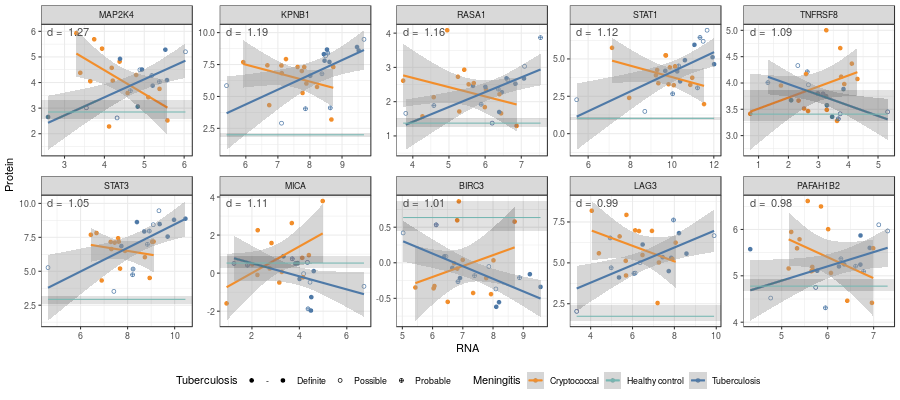

In [60]:
%%R -i df -w 900 -h 400
df = df[df$Meningitis!='Viral',]
(
    ggplot(df, aes(x=RNA, y=Protein, color=Meningitis))
    + facet_wrap('gene', 2, scale='free')
    + geom_point(aes(shape=Tuberculosis))
    + geom_smooth(method='lm')
    + geom_text(aes(label=paste('d = ', round(diff, 2))), x=-Inf, y=Inf, check_overlap=T, vjust=1.5, hjust=-0.15, color='grey30')
    + geom_rect(aes(ymin=hcp_q1, ymax=hcp_q3, xmin=-Inf, xmax=Inf), alpha=0.002, fill='grey', color=NA)
    + geom_line(aes(y=hcp_q2, ymin=hcp_q1, ymax=hcp_q3, xmin=-Inf, xmax=Inf, color='Healthy control'))
    + color_meningitis + nice_theme
    + scale_shape_manual(values=c('-'=19, 'Definite'=19, 'Probable'=10, 'Possible'=1))
)

TODO: permutation test

Top 5 (extracts from NCBI RefSeq gene reports):
- MAP2K4 (a.k.a MKK4; SEK1): Toll Like Receptor cascades, Signaling: MAPK, IL-1, IL-6, Wnt, TNF, TGF-β, FCϵ, ErbB
- KPNB1: HIV-1 replication, apoptosis, Interferon Signaling
- RASA1: stimulates the GTPase activity of RAS p21, Signaling: Aurora A, Aurora B, BCR, FCϵ, EGF/EGFR, EPO, EPHB, Insulin IL-2, IL-3,5, MAPK, NGF, VEGF, RAS and many more; T-Cell Receptor and Co-stimulatory Signaling
- STAT1: "can be activated by various ligands including interferon-alpha, interferon-gamma, EGF, PDGF and IL6 [...] mediates the expression of a variety of genes, which is thought to be important for cell viability in response to different cell stimuli and pathogens";
 - "HIV-1 infection upregulates basal mRNA levels of JUN, IL6, STAT1, CEBPA, RELA, and CEBPG in monocyte derived macrophages"
 - "HIV/**tuberculosis** coinfection upregulates STAT1 expression in pleural fluid mononuclear cells (PFMC) isolated from antiretroviral-naive coinfected patients (relative to patients infected with tuberculosis only)"
- TNFRSF8: TNF-receptor; expressed by activated T and B cells; interactions with HIV-1

The top 6 - STAT3 has a similar behaviour to STAT1 (and both are higher in TB and crypto than in HC!)

After comparing to the healthy controls we could say that KPNB1, STAT1, STAT3, BIRC3 and LAG3 may be worth investigating.

As I have held out some data (samples which are not shared are not included in is shared_protein not in shared_rna), we can now try independently validate if the abundance levels differ between crypto and TB:

TODO